# Create an ordered spill file for running the monte carlo

In [1]:
import os
import numpy
import xarray
import pandas
import pathlib
import math
from haversine import haversine
from glob import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from cartopy.io import shapereader as shpreader 
import cartopy.crs
from cartopy import feature
mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

### User inputs

In [2]:
lat = {}
lon = {}
# Order spills according to distance from BP lat/lon
lat['BP'] = 48.86111
lon['BP'] = -122.758
# directory and file names for spill csv file location
#file_dir = pathlib.Path('/ocean/rmueller/MIDOSS/spill_files/')
file_dir = pathlib.Path('/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files/')
spill_locations = file_dir / 'SalishSea_oil_spills_4.csv'

## Create spill .csv file

### Load spills file and select spills over 3 L

In [3]:
# load spill locations
spill_locs_all = pandas.read_csv(spill_locations)
# select spills over 3L
spill_locs = spill_locs_all.loc[
    spill_locs_all.spill_volume > 3
]
spill_locs.shape[0]

9833

### Calculate distance from selected lat/lon

In [4]:
for region in [*lat]:
    distance = []
    # loop through spill location and calculate distance from region epicenter
    for idx,spill_lats in enumerate(spill_locs['spill_lat']):
        spill_site = (spill_locs.spill_lat.iloc[idx], spill_locs.spill_lon.iloc[idx])
        distance.append(haversine(
            (lat[region],lon[region]), 
            spill_site
        ))

    # I tried doing a directly assign but couldn't get it to work for some reason
    spill_locs[f'distance_{region}'] = distance

/var/folders/36/r7rkkw2567v70rmk6z0twn6r0000gp/T/ipykernel_34264/3540223968.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spill_locs[f'distance_{region}'] = distance


### Sort dataframe based on distance to selected lat/lon

In [5]:
spill_locs = spill_locs.sort_values(
    by=f'distance_{region}',
    ascending=True).reset_index(drop=True)

In [6]:
# # sort the spills by distance to BP marine terminal
# spill_locs = spill_locs.sort_values(
#     by="distance_bp",
#     ascending=True).reset_index(drop=True)
# # extract the 30 closest spills to TP
# spill_locs_30["BP terminal"] = spill_locs.iloc[:nrows]
# # Save values to file
# if sortby == 'bp':
#     spill_locs.to_csv(file_dir / f'SalishSea_oil_spills_1_gt3_BP{nrows}.csv')

### Create .csv for running monte carlo

In [7]:
spill_locs.to_csv(file_dir / "SalishSea_oil_spills.csv")

## Plot spills 

### Rename oil types to those represented in model runs

In [8]:
spill_locs['Lagrangian_template'] = spill_locs['Lagrangian_template'].replace(
    ['Lagrangian_akns.dat','Lagrangian_bunker.dat',
         'Lagrangian_diesel.dat','Lagrangian_gas.dat',
         'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
         'Lagrangian_other.dat'], 
    ['ANS','Bunker-C','Diesel','Diesel',
         'Diesel', 'Dilbit', 'Bunker-C']
)

### Sort spills by oil type for plotting

In [9]:
spill_locs_byoil = {}
oil_types = [
    'ANS', 
    'Bunker-C', 
    'Dilbit', 
    'Diesel'
]
spill_locs_byoil={}
for oil in oil_types:
    spill_locs_byoil["{0}".format(oil)] = spill_locs[
        spill_locs.Lagrangian_template==oil
    ].sort_values(by='spill_volume')
    len_array = len(spill_locs_byoil[oil])
    print(f'{oil}: {len_array}')

ANS: 66
Bunker-C: 3424
Dilbit: 1
Diesel: 6342


### Plot spills 

In [10]:
max_spill_volume = max(spill_locs.spill_volume)
# Weight spill volumes by max volume for plotting 
#spill_volume_fraction = spill_locs.spill_volume/max_spill_volume 

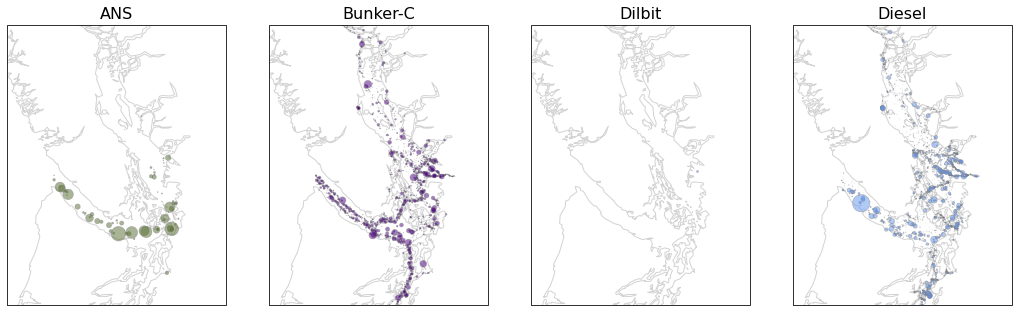

In [11]:
# define axis limits
axlim = numpy.zeros(4)
axlim[0] = -124.5
axlim[1] = -123.5
axlim[2] = spill_locs.spill_lat.min()
axlim[3] = spill_locs.spill_lat.max()

oil_colors = [
    'darkolivegreen',
    'indigo',
    'mediumslateblue',
    'cornflowerblue',
    'saddlebrown'
]
ms = 300

rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()
%matplotlib inline    
fig,axs = plt.subplots(
    1, 4, figsize=(18, 9), 
    subplot_kw={"projection": rotated_crs, "facecolor": "white"}
)
fig.subplots_adjust(hspace=0.5)
terminal_loc = 0
for plot_index,oil in enumerate([*spill_locs_byoil]):
    spill_volume_fraction = spill_locs_byoil[oil].spill_volume/max_spill_volume
#       print(plot_index)
    axs[plot_index].add_feature(feature.GSHHSFeature(
        'auto', 
        edgecolor='lightgrey', 
        facecolor='none'
    ), zorder=1)
    scatter_bunker = axs[plot_index].scatter(spill_locs_byoil[oil].spill_lon, 
           spill_locs_byoil[oil].spill_lat, 
           s = ms * spill_volume_fraction,
           #label = spill_volume_fraction['bunker'].values.tolist(),
           color=oil_colors[plot_index],
           alpha = 0.5,
           edgecolors='grey',
           linewidth=0.7,
           transform=plain_crs,
           zorder=2)
    axs[plot_index].set_title(oil)
    axs[plot_index].set_extent(axlim, crs=plain_crs)

fig.canvas.draw()
#fig.tight_layout()
plt.show()

## Show location of first 30 spills 

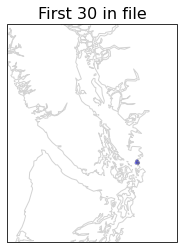

In [12]:
nspills = 30
fig,axs = plt.subplots(
    1,figsize=(4, 4), 
    subplot_kw={"projection": rotated_crs, "facecolor": "white"}
)
fig.subplots_adjust(hspace=0.5)
axs.add_feature(feature.GSHHSFeature(
    'auto', 
    edgecolor='lightgrey', 
    facecolor='none'
), zorder=1)
scatter_bunker = axs.scatter(spill_locs.spill_lon[:nspills], 
       spill_locs.spill_lat[:nspills], 
       s = ms * spill_locs.spill_volume[:nspills]/max_spill_volume,
       #label = spill_volume_fraction['bunker'].values.tolist(),
       color='blue',
       alpha = 0.5,
       edgecolors='grey',
       linewidth=0.7,
       transform=plain_crs,
       zorder=2)
axs.set_title(f'First {nspills} in file')
axs.set_extent(axlim, crs=plain_crs)


## Show spills from all files 

In [13]:
df={}
filenames = sorted(glob(os.path.join(file_dir,"*.csv")))
for index,fn in enumerate(filenames):
    print(index,fn)
    df[index] = pandas.read_csv(fn)
    # rename lagrangian files as oil types (for plotting)
    df[index]['Lagrangian_template'] = df[index]['Lagrangian_template'].replace(
        ['Lagrangian_akns.dat','Lagrangian_bunker.dat',
             'Lagrangian_diesel.dat','Lagrangian_gas.dat',
             'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
             'Lagrangian_other.dat'], 
        ['ANS','Bunker-C','Diesel','Diesel',
             'Diesel', 'Dilbit', 'Bunker-C']
    )
    if index == 0:
        df_combined = df[index].copy()
    else:
        df_combined = pandas.concat([df_combined, df[index]])

0 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files/SalishSea_oil_spills.csv
1 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files/SalishSea_oil_spills_1.csv
2 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files/SalishSea_oil_spills_2.csv
3 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files/SalishSea_oil_spills_3.csv
4 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files/SalishSea_oil_spills_4.csv
5 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files/SalishSea_oil_spills_5.csv
6 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files/SalishSea_oil_spills_6.csv
7 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files/SalishSea_oil_spills_7.csv
8 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files/SalishSea_oil_spills_8.csv
9 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files/SalishSea_oil_spills_9.csv


In [14]:
spill_locs_byoil={}
for file_index,file in enumerate(filenames):
    spill_locs_byoil[file_index]={}
    for oil in oil_types:
        spill_locs_byoil[file_index]["{0}".format(oil)] = df[file_index][
            df[file_index].Lagrangian_template==oil
        ].sort_values(by='spill_volume')
        len_array = len(spill_locs_byoil[file_index][oil])

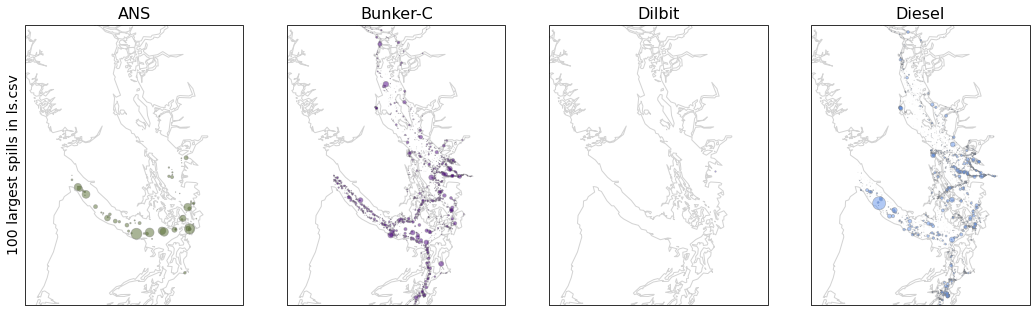

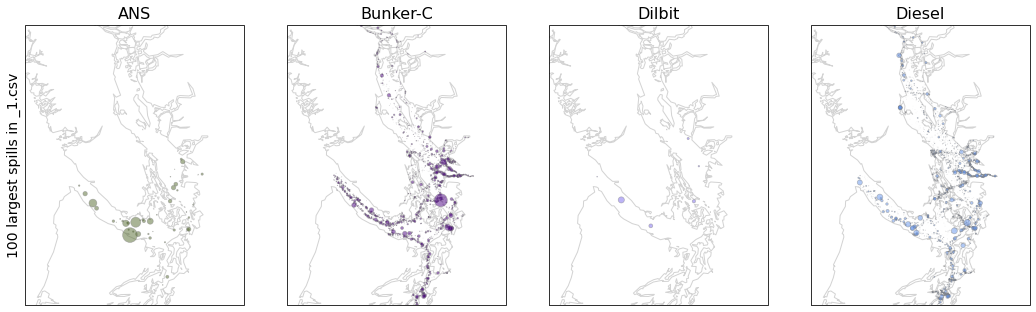

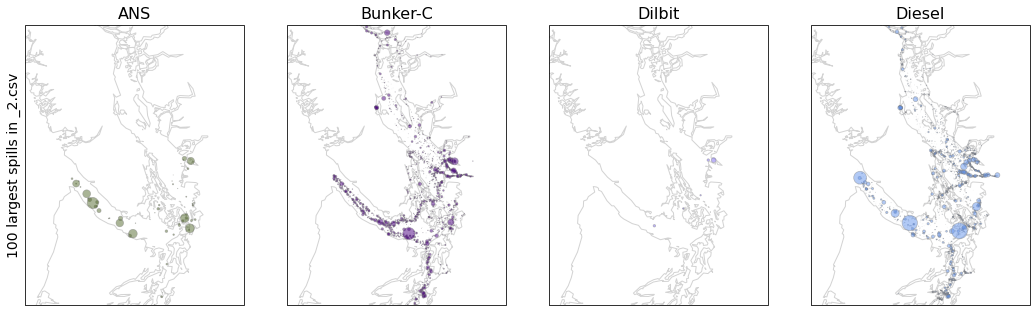

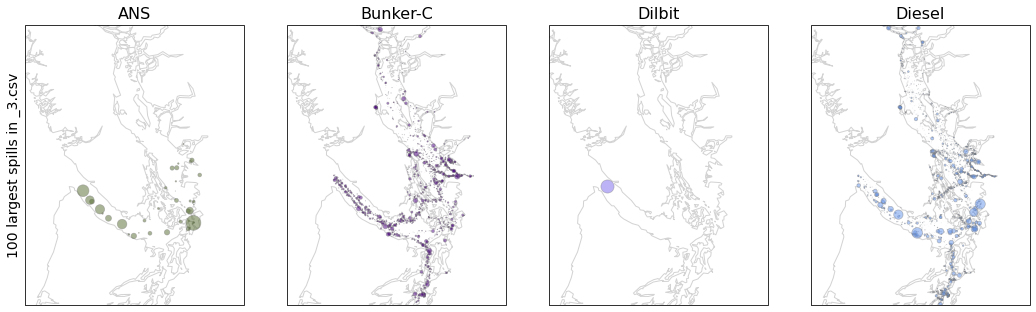

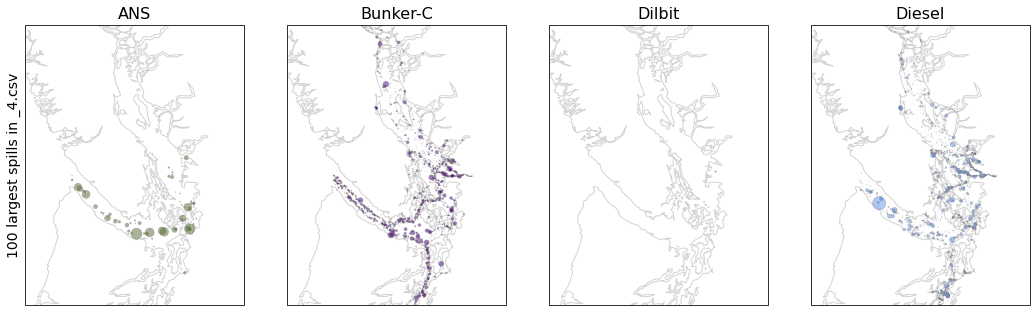

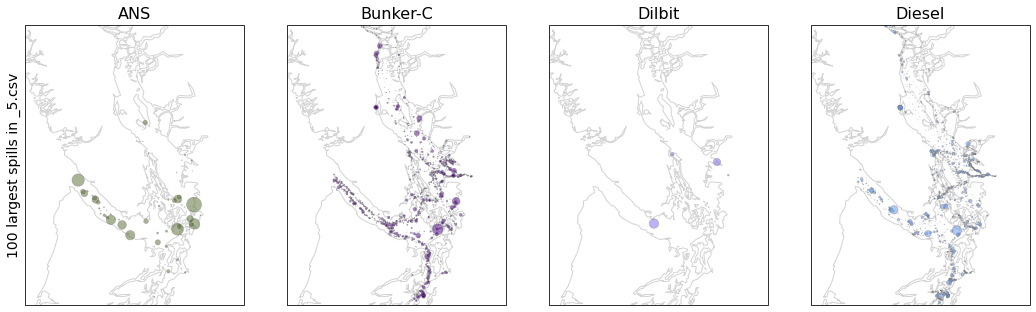

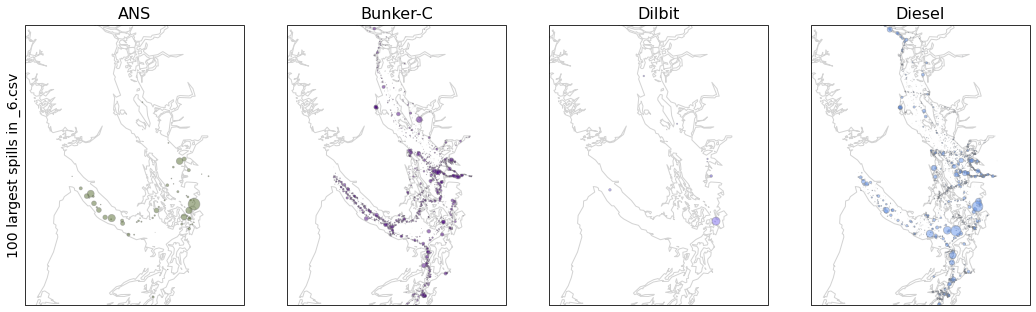

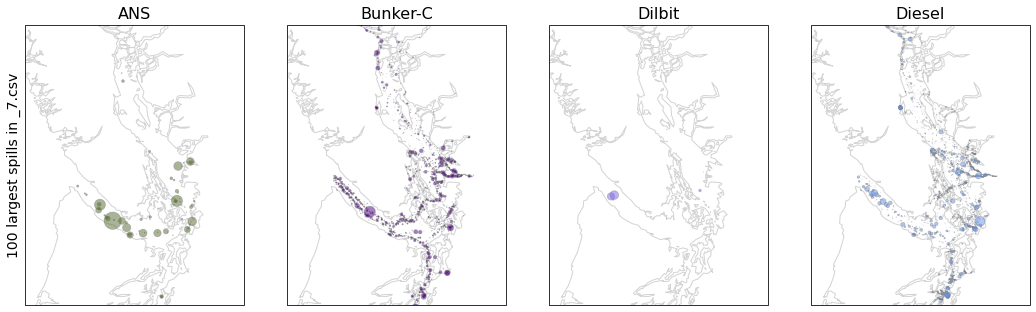

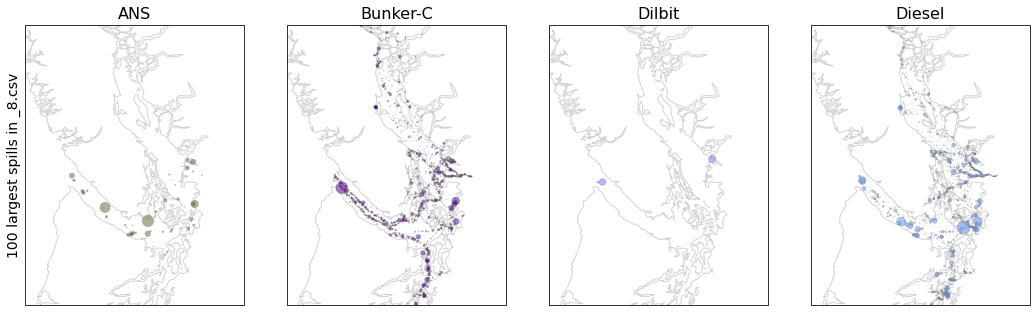

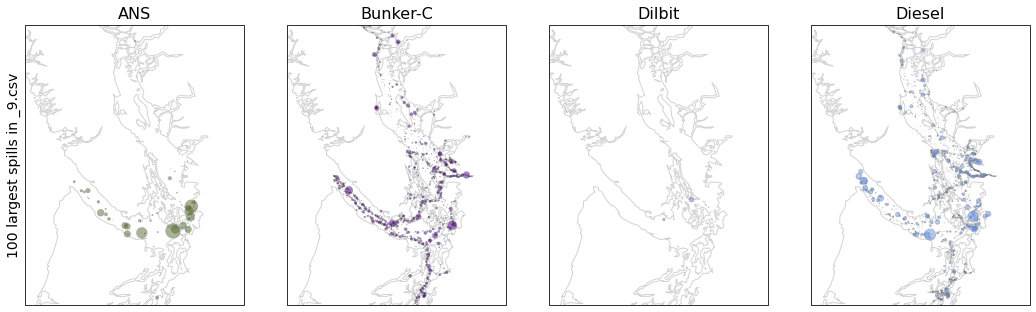

In [15]:
spill_volume_fraction={}
max_spill_volume  = max(df_combined.spill_volume)
for file_index,file in enumerate(filenames):
    fig,axs = plt.subplots(
        1, 4, figsize=(18, 9), 
        subplot_kw={"projection": rotated_crs, "facecolor": "white"}
    )
    fig.subplots_adjust(hspace=0.5)
    terminal_loc = 0
    for plot_index,oil in enumerate([*spill_locs_byoil[file_index]]):
        spill_volume_fraction[file_index] = spill_locs_byoil[file_index][oil].spill_volume/max_spill_volume
 #       print(plot_index)
        axs[plot_index].add_feature(feature.GSHHSFeature(
            'auto', 
            edgecolor='lightgrey', 
            facecolor='none'
        ), zorder=1)
        scatter_bunker = axs[plot_index].scatter(spill_locs_byoil[file_index][oil].spill_lon, 
               spill_locs_byoil[file_index][oil].spill_lat, 
               s = ms * spill_volume_fraction[file_index],
               #label = spill_volume_fraction['bunker'].values.tolist(),
               color=oil_colors[plot_index],
               alpha = 0.5,
               edgecolors='grey',
               linewidth=0.7,
               transform=plain_crs,
               zorder=2)
    #     handles, labels = scatter_bunker.legend_elements(prop="sizes", color=oil_colors[1], num=3, alpha=1)
    #     legend = axs[plot_index].legend(handles, labels, loc="upper right", title="volume (liters)")
    #     plt.setp(legend.get_title(),fontsize='xx-large')
        axs[plot_index].set_title(oil)
        axs[plot_index].set_extent(axlim, crs=plain_crs)
    
    axs[0].text(-0.05,0.5,'100 largest spills in ' + filenames[file_index][-6:],
        rotation = 90,
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs[0].transAxes,
        fontsize = 14)
    fig.canvas.draw()
    #fig.tight_layout()

    index += 1
    plt.show()

## Plot spills from previous iteration of `random-oil-spills` 

In [16]:
df={}
file_dir = pathlib.Path('/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_mctest/')
filenames = sorted(glob(os.path.join(file_dir,"*.csv")))
for index,fn in enumerate(filenames):
    print(index,fn)
    df[index] = pandas.read_csv(fn)
    # rename lagrangian files as oil types (for plotting)
    df[index]['Lagrangian_template'] = df[index]['Lagrangian_template'].replace(
        ['Lagrangian_akns.dat','Lagrangian_bunker.dat',
             'Lagrangian_diesel.dat','Lagrangian_gas.dat',
             'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
             'Lagrangian_other.dat'], 
        ['ANS','Bunker-C','Diesel','Diesel',
             'Diesel', 'Dilbit', 'Bunker-C']
    )
    if index == 0:
        df_combined = df[index].copy()
    else:
        df_combined = pandas.concat([df_combined, df[index]])

0 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_mctest/SalishSea_oil_spills_1.csv
1 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_mctest/SalishSea_oil_spills_2.csv
2 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_mctest/SalishSea_oil_spills_3.csv
3 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_mctest/SalishSea_oil_spills_4.csv
4 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_mctest/SalishSea_oil_spills_5.csv
5 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_mctest/SalishSea_oil_spills_7.csv
6 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_mctest/SalishSea_oil_spills_8.csv


In [17]:
spill_locs_byoil={}
for file_index,file in enumerate(filenames):
    spill_locs_byoil[file_index]={}
    for oil in oil_types:
        spill_locs_byoil[file_index]["{0}".format(oil)] = df[file_index][
            df[file_index].Lagrangian_template==oil
        ].sort_values(by='spill_volume')
        len_array = len(spill_locs_byoil[file_index][oil])

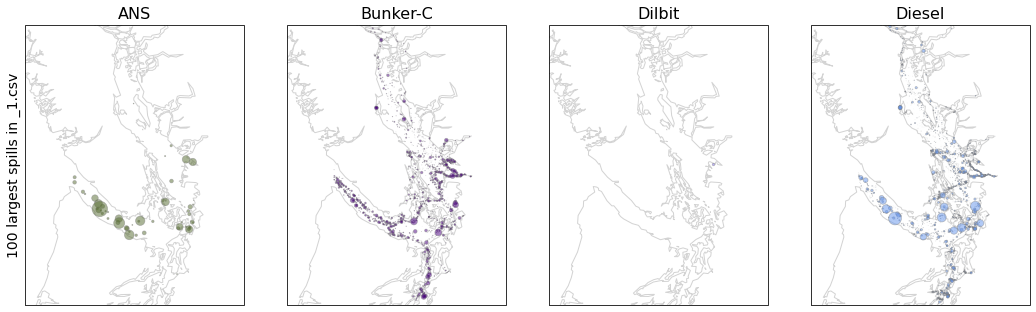

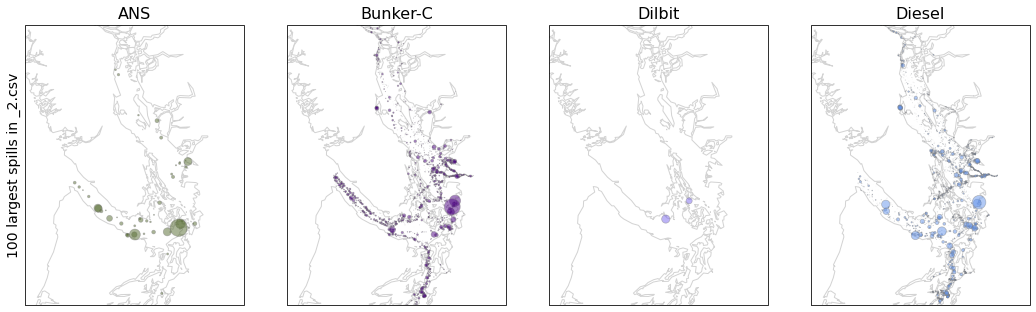

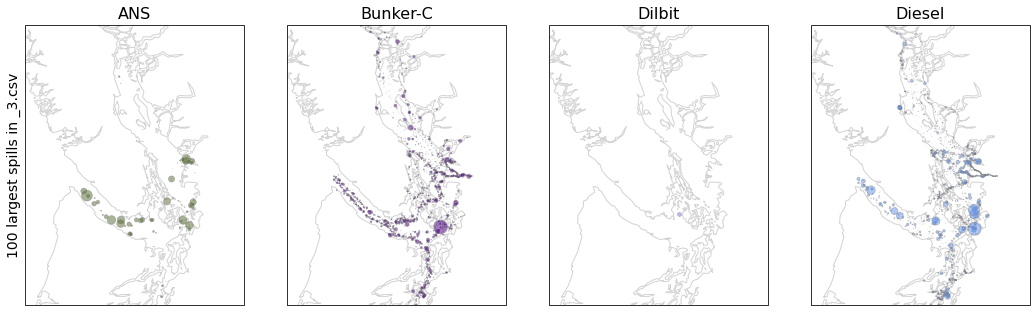

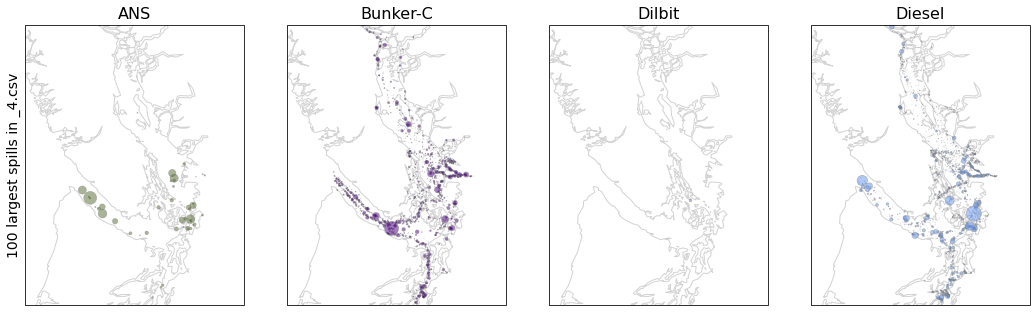

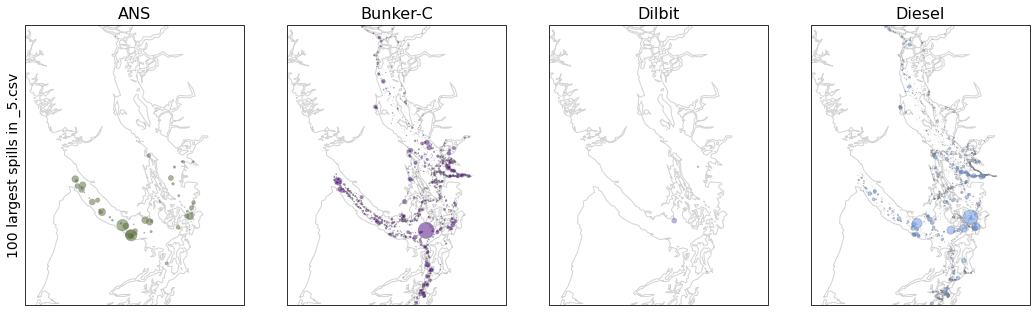

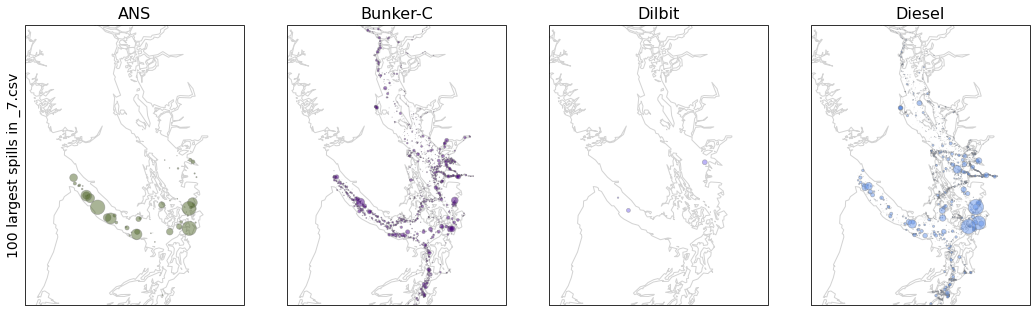

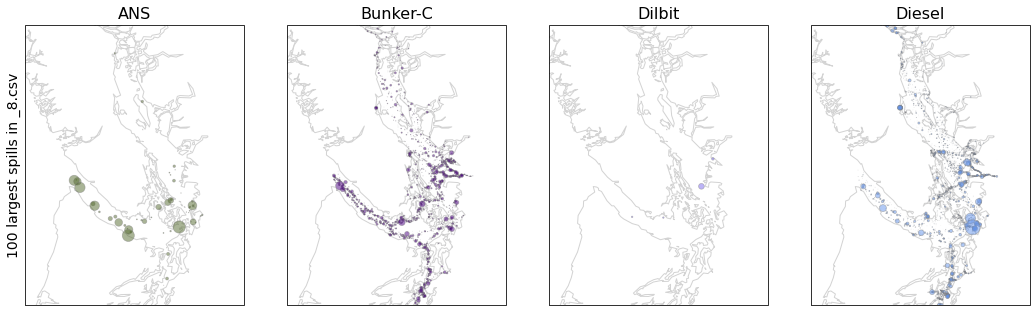

In [18]:
spill_volume_fraction={}
max_spill_volume  = max(df_combined.spill_volume)
for file_index,file in enumerate(filenames):
    fig,axs = plt.subplots(
        1, 4, figsize=(18, 9), 
        subplot_kw={"projection": rotated_crs, "facecolor": "white"}
    )
    fig.subplots_adjust(hspace=0.5)
    terminal_loc = 0
    for plot_index,oil in enumerate([*spill_locs_byoil[file_index]]):
        spill_volume_fraction[file_index] = spill_locs_byoil[file_index][oil].spill_volume/max_spill_volume
 #       print(plot_index)
        axs[plot_index].add_feature(feature.GSHHSFeature(
            'auto', 
            edgecolor='lightgrey', 
            facecolor='none'
        ), zorder=1)
        scatter_bunker = axs[plot_index].scatter(spill_locs_byoil[file_index][oil].spill_lon, 
               spill_locs_byoil[file_index][oil].spill_lat, 
               s = ms * spill_volume_fraction[file_index],
               #label = spill_volume_fraction['bunker'].values.tolist(),
               color=oil_colors[plot_index],
               alpha = 0.5,
               edgecolors='grey',
               linewidth=0.7,
               transform=plain_crs,
               zorder=2)
    #     handles, labels = scatter_bunker.legend_elements(prop="sizes", color=oil_colors[1], num=3, alpha=1)
    #     legend = axs[plot_index].legend(handles, labels, loc="upper right", title="volume (liters)")
    #     plt.setp(legend.get_title(),fontsize='xx-large')
        axs[plot_index].set_title(oil)
        axs[plot_index].set_extent(axlim, crs=plain_crs)
    
    axs[0].text(-0.05,0.5,'100 largest spills in ' + filenames[file_index][-6:],
        rotation = 90,
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs[0].transAxes,
        fontsize = 14)
    fig.canvas.draw()
    #fig.tight_layout()

    index += 1
    plt.show()